/Users/samsonkoelle/manifoldflasso_jmlr
preembed January_18_2021_11_00_58


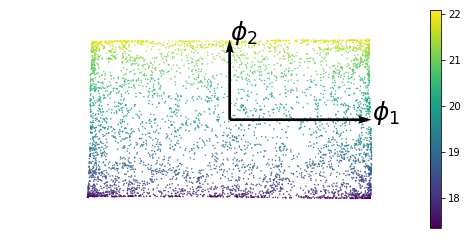

In [1]:
import matplotlib
matplotlib.use('Agg')
import os
import matplotlib.pyplot as plt
import datetime
import numpy as np
import dill as pickle
import random
from shutil import copyfile
import sys
import copy
np.random.seed(0)
random.seed(0)
now = datetime.datetime.now().strftime("%B_%d_%Y_%H_%M_%S")
workingdirectory = '/Users/samsonkoelle/manifoldflasso_jmlr'
#workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)
#print(os.getcwd())
#from codes.experimentclasses.SwissRoll49 import SwissRoll49


from codes.flasso.FlassoManifold import FlassoManifold
from codes.geometer.RiemannianManifold import RiemannianManifold
from codes.otherfunctions.data_stream import data_stream
from codes.geometer.ShapeSpace import compute3angles
import numpy as np
from scipy.stats import special_ortho_group
import math
from pathos.multiprocessing import ProcessingPool as Pool

# def rotator(rotatee, theta):
#     rm = np.asarray([[np.cos(theta), - np.sin(theta)],[np.sin(theta), np.cos(theta)]])
#     rm2 = np.zeros((49,49))
#     for i in range(24):
#         rm2[(2*i):(2*(i+1)),(2*i):(2*(i+1))] = rm
#     rm2[48,48] = 1.
#     output = np.matmul(rm2, rotatee.transpose())
#     return(output.transpose())

def get_grad(t):
    output = np.zeros((49,2))
    output[0,0] = ((np.cos(t) - t*np.sin(t)) / (np.sin(t) + t*np.cos(t)))
    output[2,0] = 1.
    output[1,1] = 1.
    output = output / np.linalg.norm(output, axis = 0)
    return(output)

def dup_cols(a, indx, num_dups=1):
    return np.insert(a,[indx+1]*num_dups,a[:,[indx]],axis=1)

class SwissRoll49(FlassoManifold):
    """
    Parameters
    ----------
    cor : string,
        Data file to load
    xvar : np.array(dtype = int),
        List of adjacencies
    jj : np.array,
        List of adjacencies part 2
    d : int,
        dimension over which to evaluate the radii (smaller usually better)
    rmin : float,
        smallest radius ( = rad_bw_ratio * bandwidth) to consider
    rmax : float,
        largest radius ( = rad_bw_ratio * bandwidth) to consider
    ntry : int,
        number of radii between rmax and rmin to try
    run_parallel : bool,
        whether to run the analysis in parallel over radii
    search_space : str,
        either 'linspace' or 'logspace', choose to search in log or linear space
    rad_bw_ratio : float,
        the ratio of radius and kernel bandwidth, default to be 3 (radius = 3*h)
    Methods
    -------
    generate_data :
        Simulates data
    get_atoms_4 :
    	Gets atomic tetrahedra based off of ii and jj
    get_atoms_3 :
    	Gets triples of atoms

    """

    # AtomicRegression(dim, ii, jj, filename)
    def __init__(self,  xvar,cores, noise):
        natoms = 9
        self.xvar = xvar
        self.cores = cores
        self.noise = noise
        self.dim = 2
        self.d = 49
        self.p = 51

    def generate_data(self, n,theta):
        self.n = n
        d = self.d
        xvar = self.xvar
        dim = self.dim
        noise = self.noise
        self.theta = theta
        ts = .75 * np.pi * (1 + 2 * np.random.uniform(low=0.0, high=1.0, size=n)) + 15
        #ts = np.pi * (1 + 2 * np.random.uniform(low=0.0, high=1.0, size=n)) + 15
        #ts = 1.5*np.pi * (1 + 2 * np.random.uniform(low=0.0, high=1.0, size=n)) + 15
        x = ts * np.cos(ts)
        y = 101 * np.random.uniform(low=0.0, high=1.0, size=n)
        self.ys = y
        z = ts * np.sin(ts)
        self.ts = ts
        X = np.vstack((x, y, z))
        #X += noise * generator.randn(3, n_samples)
        X = X.T
        unrotated_data = np.zeros((n,49))
        unrotated_data[:,:3] = X
        rotator = special_ortho_group.rvs(49)
        #rotator = np.identity(49)
        self.rotator = rotator
        data = np.matmul(unrotated_data, rotator)
        if xvar != 0.:
            data += np.random.multivariate_normal(np.zeros(49),np.identity(49)*xvar, n)
        #for i in range(n):
        #    #print(i)
        #    data[i] += np.random.multivariate_normal(np.zeros(49),np.identity(49)*xvar)
        #data = rotator(X,theta)
        #data = dup_cols(data, indx=0, num_dups=46)
        #data = np.reshape(results, (n, (d)))
        return (RiemannianManifold(data, dim))

    def get_dx_g_full(self, data):
        d = self.d
        p = self.p
        #n = data.shape[0]
        n = len(self.selected_points)
        ts = self.ts[self.selected_points]
        grads = np.asarray([get_grad(t) for t in ts])
        rotator = self.rotator
        #grads2 = rotator(grads, theta)
        fullgrads = np.zeros((n, d, p))
        for i in range(n):
            fullgrads[i, :, 0:2] = np.matmul(rotator.transpose(), grads[i])
            fullgrads[i, :, 2:] = np.identity(49)
        output = np.swapaxes(fullgrads,1,2)
        return (output)


    def get_dx_g_full_2(self, selected_points):
        d = self.d
        p = self.p
        #n = data.shape[0]
        n = len(selected_points)
        ts = self.ts[selected_points]
        grads = np.asarray([get_grad(t) for t in ts])
        rotator = self.rotator
        #grads2 = rotator(grads, theta)
        fullgrads = np.zeros((n, d, p))
        for i in range(n):
            #040220 added transpose... then removed
            fullgrads[i, :, 0:2] = np.matmul(rotator.transpose(), grads[i])
            fullgrads[i, :, 2:] = np.identity(49)
        output = np.swapaxes(fullgrads,1,2)
        return (output)
    
from codes.otherfunctions.multirun import get_coeffs_and_lambdas
from codes.otherfunctions.multirun import get_support
from codes.otherfunctions.multiplot import plot_support_2d
from codes.otherfunctions.multiplot import plot_reg_path_ax_lambdasearch
from codes.otherfunctions.multiplot import plot_gs_v_dgnorm
from codes.otherfunctions.multirun import get_cosines
from codes.otherfunctions.multiplot import plot_reg_path_ax_lambdasearch_customcolors
#from codes.otherfunctions.multirun import get_grads_reps_noshape
from codes.otherfunctions.multiplot import plot_betas_customcolors2
from codes.otherfunctions.multirun import get_support_recovery_lambda
from codes.otherfunctions.multirun import get_lower_interesting_lambda
from codes.otherfunctions.multirun import get_grads_noshape_swiss
from codes.flasso.Replicate import Replicate
from megaman.embedding import LTSA
from megaman.embedding import Isomap
import matplotlib.pyplot as plt

def get_betas_spam2(xs, ys, groups, lambdas, n, q, itermax, tol):
    # n = xs.shape[0]
    p = len(np.unique(groups))
    lambdas = np.asarray(lambdas, dtype=np.float64)
    yadd = np.expand_dims(ys, 1)
    groups = np.asarray(groups, dtype=np.int32) + 1
    W0 = np.zeros((xs.shape[1], yadd.shape[1]), dtype=np.float32)
    Xsam = np.asfortranarray(xs, dtype=np.float32)
    Ysam = np.asfortranarray(yadd, dtype=np.float32)
    coeffs = np.zeros((len(lambdas), q, n, p))
    for i in range(len(lambdas)):
        # alpha = spams.fistaFlat(Xsam,Dsam2,alpha0sam,ind_groupsam,lambda1 = lambdas[i],mode = mode,itermax = itermax,tol = tol,numThreads = numThreads, regul = "group-lasso-l2")
        # spams.fistaFlat(Y,X,W0,TRUE,numThreads = 1,verbose = TRUE,lambda1 = 0.05, it0 = 10, max_it = 200,L0 = 0.1, tol = 1e-3, intercept = FALSE,pos = FALSE,compute_gram = TRUE, loss = 'square',regul = 'l1')
        output = spams.fistaFlat(Ysam, Xsam, W0, True, groups=groups, numThreads=-1, verbose=True,
                                     lambda1=lambdas[i], it0=100, max_it=itermax, L0=0.5, tol=tol, intercept=False,
                                     pos=False, compute_gram=True, loss='square', regul='group-lasso-l2', ista=False,
                                     subgrad=False, a=0.1, b=1000)
        coeffs[i, :, :, :] = np.reshape(output[0], (q, n, p))
        # print(output[1])
    return (coeffs)

def get_coeffs(experiment, lambdas, itermax, nsel, tol):
    experiment.xtrain, experiment.groups = experiment.construct_X_js(experiment.dg_M)
    experiment.ytrain = experiment.construct_Y_js(experiment.df_M)
    experiment.coeffs = get_betas_spam2(experiment.xtrain, experiment.ytrain, experiment.groups, lambdas,
                                        nsel, experiment.q, itermax, tol)
    return (experiment)

def get_coeffs_parallel(experiments, nreps, lambdas, itermax, nsel, tol, cores):
    p = Pool(cores)
    results = p.map(
        lambda i: get_coeffs(experiment=experiments[i], lambdas=lambdas, itermax=itermax, nsel=nsel, tol=tol),
        range(nreps))
    output = {}
    for i in range(nreps):
        output[i] = results[i]
    return (output)

from pathos.multiprocessing import ProcessingPool as Pool
import spams

#set parameters
n = 5000 #number of data points to simulate
nsel = 5 #number of points to analyze with lasso
itermax = 1000 #maximum iterations per lasso run
tol = 1e-10 #convergence criteria for lasso
#lambdas = np.asarray([5,10,15,20,25,50,75,100], dtype = np.float16)#lambda values for lasso
#lambdas = np.asarray([0,2.95339658e-06, 5.90679317e-06, 8.86018975e-06, 1.18135863e-05,
#       1.47669829e-05, 2.95339658e-05, 4.43009487e-05, 5.90679317e-05])
lambdas = np.asarray([0,.1,1,10,100], dtype = np.float64)
n_neighbors = 1000 #number of neighbors in megaman
n_components = 2 #number of embedding dimensions (diffusion maps)
#10000 points and .17 dt is best so far
#100000 and .05 is better
#thats with 50 neighbors
#diffusion_time = 0.05 #diffusion time controls gaussian kernel radius per gradients paper
#diffusion_time = 0.1
#diffusion_time = 0.25
diffusion_time = 1.
nreps = 2
m = 2
dimnoise = 2
dim = 2 #manifold dimension
cores = 16 #number of cores for parallel processing
p = 51
lambda_max = 1
max_search = 30

folder = workingdirectory + '/Figures/swissroll/' + now + 'n' + str(n) + 'nsel' + str(nsel) + 'nreps' + str(nreps)
os.mkdir(folder)
#src = workingdirectory + '/codes/experiments/swissroll_multi_moredim_040220.py'
#filenamescript = folder + '/script.py'
#copyfile(src, filenamescript)

new_MN = True
savename = 'swissroll_041420_5k'
savefolder = 'swissroll'
loadfolder = 'swissroll'
loadname = 'swissroll_041420_5k'
if new_MN == True:
    experiment = SwissRoll49(xvar = 0.0,cores = cores, noise = False)
    experiment.M = experiment.generate_data(n=n,theta=np.pi / 4)  # if noise == False then noise parameters are overriden
    experiment.q = n_components
    experiment.M.geom = experiment.M.compute_geom(diffusion_time, n_neighbors)
    print('preembed', datetime.datetime.now().strftime("%B_%d_%Y_%H_%M_%S"))
    experiment.N = experiment.M.get_embedding3(experiment.M.geom, n_components, diffusion_time, dim)

#     with open(workingdirectory + '/untracked_data/embeddings/' + savefolder + '/' + savename + '.pkl' ,
#              'wb') as output:
#          pickle.dump(experiment, output, pickle.HIGHEST_PROTOCOL)
# else:
#     file = open(workingdirectory + '/untracked_data/embeddings/' + savefolder + '/' + savename + '.pkl', 'rb')
#     experiment = pickle.load(file)
#     file.close()


#%matplotlib inline
#experiment.N.plot([0,1], list(range(n)), experiment.ts, 1,1,folder + '/internal_1_xxx')

In [2]:
# #set parameters
# n = 5000 #number of data points to simulate
# nsel = 5 #number of points to analyze with lasso
# itermax = 1000 #maximum iterations per lasso run
# tol = 1e-10 #convergence criteria for lasso
# #lambdas = np.asarray([5,10,15,20,25,50,75,100], dtype = np.float16)#lambda values for lasso
# #lambdas = np.asarray([0,2.95339658e-06, 5.90679317e-06, 8.86018975e-06, 1.18135863e-05,
# #       1.47669829e-05, 2.95339658e-05, 4.43009487e-05, 5.90679317e-05])
# lambdas = np.asarray([0,.1,1,10,100], dtype = np.float64)
# n_neighbors = 1000 #number of neighbors in megaman
# n_components = 2 #number of embedding dimensions (diffusion maps)
# #10000 points and .17 dt is best so far
# #100000 and .05 is better
# #thats with 50 neighbors
# #diffusion_time = 0.05 #diffusion time controls gaussian kernel radius per gradients paper
# #diffusion_time = 0.1
# #diffusion_time = 0.25
# diffusion_time = 1.
# nreps = 2
# m = 2
# dimnoise = 2
# dim = 2 #manifold dimension
# cores = 16 #number of cores for parallel processing
# p = 51
# lambda_max = 1
# max_search = 30

# #folder = workingdirectory + '/Figures/swissroll/' + now + 'n' + str(n) + 'nsel' + str(nsel) + 'nreps' + str(nreps)
# #os.mkdir(folder)
# #src = workingdirectory + '/codes/experiments/swissroll_multi_moredim_040220.py'
# #filenamescript = folder + '/script.py'
# #copyfile(src, filenamescript)

# new_MN = True
# savename = 'swissroll_041420_5k'
# savefolder = 'swissroll'
# loadfolder = 'swissroll'
# loadname = 'swissroll_041420_5k'
# if new_MN == True:
#     experiment = SwissRoll49(xvar = 0.0,cores = cores, noise = False)
#     experiment.M = experiment.generate_data(n=n,theta=np.pi / 4)  # if noise == False then noise parameters are overriden
 

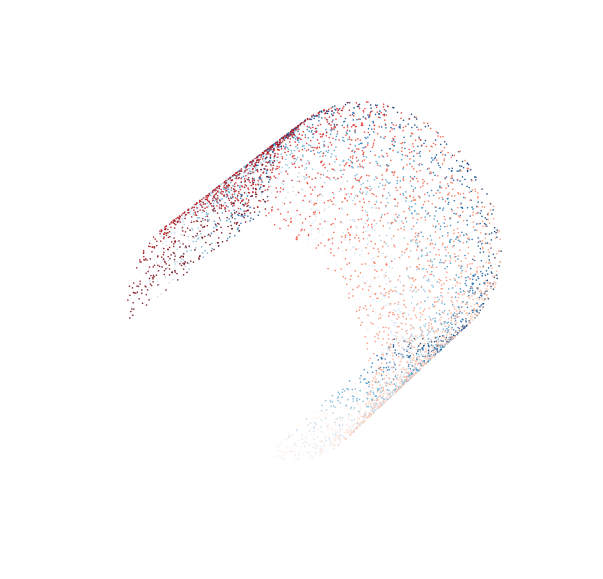

In [3]:
unr = experiment.M.data @ experiment.rotator.transpose()
data = unr[:,:3]

fig, axes_all = plt.subplots(figsize=(10,10))
axes_all.set_axis_off()
#axes_all[1].set_axis_off()
#axes_all[0,2].set_axis_off()
alpha = .05
ax = fig.add_subplot(1,1,1, projection='3d')
#selected_points = np.asarray(list(range(10000)))
#c = experiment.gs[selected_points,0]
x = data[:, 0]
y = data[:, 1]
z = data[:, 2]
#fig = plt.figure(figsize=(15,10))
#print(pos, nrows, ncols)
#ax = fig.add_subplot(pos, nrows, ncols, projection='3d')
s = 1
alpha = 1.
set1  = list(range(2500))
set2 = np.asarray(list(range(2500))) + 2500
ax.scatter(x[set1], y[set1], z[set1], s=s, alpha=alpha, marker='.', c = experiment.ts[set1], cmap = 'Reds')
ax.scatter(x[set2], y[set2], z[set2], s=s, alpha=alpha, marker='.', c = experiment.ys[set2], cmap = 'Blues')
ax.set_axis_off()
# ax.set_xlabel(r'$\phi_1$', fontsize=50)
# ax.set_ylabel(r'$\phi_2$', fontsize=50)
# ax.set_zlabel(r'$\phi_3$', fontsize=50)
    

In [4]:
from codes.geometer.RiemannianManifold import RiemannianManifold
from megaman.geometry import RiemannMetric
N_internal = RiemannianManifold(np.asarray([experiment.ts ,experiment.ys]).transpose(),2)
d = dim
geom = experiment.M.geom
geom.rmetric = RiemannMetric(N_internal.data,experiment.M.geom.laplacian_matrix,n_dim=d)
geom.rmetric.get_rmetric()
N_internal.geom = geom
#df_M,dg_M,dg_x ,dgx_norm  = get_grads_noshape_swiss(experiment, experiment.M, N2, selected_points)

selected_points_save = np.zeros((nreps,nsel))
experiment.p = p
experiment.itermax = itermax
experiment.tol = tol
experiment.dnoise = dim
experiment.nreps = nreps
experiment.nsel = nsel
experiment.dimnoise = dimnoise
experiment.m = m
replicates = {}
selected_points_save = np.zeros((nreps,nsel), dtype = int)
# for i in range(nreps):
#     selected_points = np.random.choice(list(range(n)),nsel,replace = False)
#     selected_points_save[i] = selected_points
#     replicates[i] = Replicate()
#     replicates[i].nsel = nsel
#     replicates[i].selected_points = selected_points
#     replicates[i].df_M,replicates[i].dg_M,replicates[i].dg_x ,replicates[i].dgx_norm  = get_grads_noshape_swiss(experiment, experiment.M, N_internal, selected_points)
#     replicates[i].xtrain, replicates[i].groups = experiment.construct_X_js(replicates[i].dg_M)
#     replicates[i].ytrain = experiment.construct_Y_js(replicates[i].df_M,dimnoise)
#     replicates[i].coeff_dict = {}
#     replicates[i].coeff_dict[0] = experiment.get_betas_spam2(replicates[i].xtrain, replicates[i].ytrain, replicates[i].groups, np.asarray([0]), nsel, experiment.m, itermax, tol)
#     replicates[i].combined_norms = {}
#     replicates[i].combined_norms[0] = np.linalg.norm(np.linalg.norm(replicates[i].coeff_dict[0][:, :, :, :], axis=2), axis=1)[0,:]
#     replicates[i].higher_lambda,replicates[i].coeff_dict,replicates[i].combined_norms = get_support_recovery_lambda(experiment, replicates[i],  lambda_max, max_search,dim)
#     replicates[i].lower_lambda,replicates[i].coeff_dict,replicates[i].combined_norms = get_lower_interesting_lambda(experiment, replicates[i],  lambda_max, max_search)
#     #= experiment.get_betas_spam2(replicates[i].xtrain, replicates[i].ytrain, replicates[i].groups, lambdas, len(selected_points), n_embedding_coordinates, itermax, tol)



In [5]:
from codes.otherfunctions.multirun import get_grads_noshape_swiss

In [14]:
swiss_internal = np.asarray([experiment.ts ,experiment.ys]).transpose()

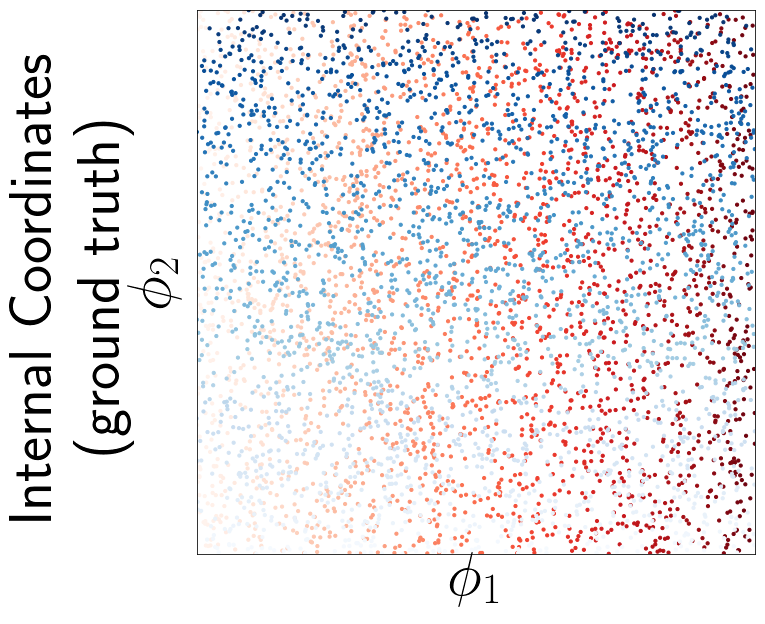

In [91]:
%matplotlib inline
fig, axes_all = plt.subplots(figsize=(10,10) )
inds1 = np.asarray(list(range(2500)))*2
inds2 = np.asarray(list(range(2500)))*2 + 1
axes_all.scatter(swiss_internal[inds1,0],swiss_internal[inds1,1], s = 10, alpha = 1, c = swiss_internal[inds1,0], cmap = 'Reds')
axes_all.scatter(swiss_internal[inds2,0],swiss_internal[inds2,1], s =10, alpha = 1, c = swiss_internal[inds2,1], cmap = 'Blues')
axes_all.set_xlim(swiss_internal[:,0].min(), swiss_internal[:,0].max())
axes_all.set_ylim(swiss_internal[:,1].min(), swiss_internal[:,1].max())
axes_all.set_xticks([])
axes_all.set_yticks([])
#axes_all[0,0].set_ylabel(r'$\phi_2$')
#axes_all[0,0].set_xlabel(r'$\phi_1$')
axes_all.set_xlabel(r'$\phi_1$', fontsize = 60)
axes_all.set_ylabel(r'$\phi_2$', fontsize = 60)
fig.text(-0.05, 0.5, 'Internal Coordinates \n (ground truth)', ha='center', va='center', rotation='vertical', fontsize = 60)
plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/sr_internal', bbox_inches = "tight")


In [16]:
N_spectral = experiment.N
geom_spectral = experiment.M.geom
geom_spectral.rmetric = RiemannMetric(N_spectral.data,experiment.M.geom.laplacian_matrix,n_dim=d)
geom_spectral.rmetric.get_rmetric()
N_spectral.geom = geom_spectral

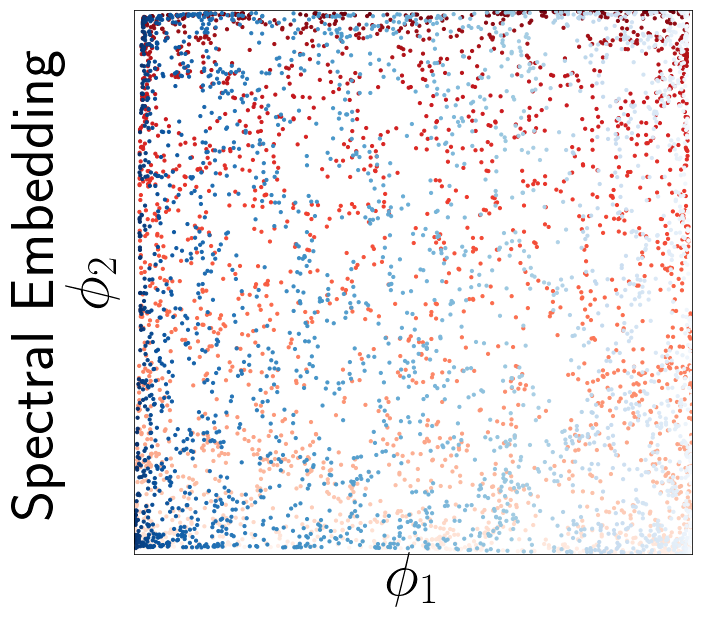

In [90]:
%matplotlib inline
fig, axes_all = plt.subplots(figsize=(10,10) )
swiss_spectral = N_spectral.data
axes_all.scatter(swiss_spectral[inds1,0],swiss_spectral[inds1,1], s = 10, alpha = 1, c = swiss_internal[inds1,0], cmap = 'Reds')
axes_all.scatter(swiss_spectral[inds2,0],swiss_spectral[inds2,1], s =10, alpha = 1, c = swiss_internal[inds2,1], cmap = 'Blues')
axes_all.set_xlim(swiss_spectral[:,0].min(), swiss_spectral[:,0].max())
axes_all.set_ylim(swiss_spectral[:,1].min(), swiss_spectral[:,1].max())
axes_all.set_xticks([])
axes_all.set_yticks([])
#axes_all[1,0].set_ylabel(r'$\phi_2$')
#axes_all[1,0].set_xlabel(r'$\phi_1$')
axes_all.set_xlabel(r'$\phi_1$', fontsize = 60)
axes_all.set_ylabel(r'$\phi_2$', fontsize = 60)
#secax = axes_all[1,0].secondary_yaxis('left')# functions=(deg2rad, rad2deg))
#secax.set_text(x 'Spectral Embedding', labelpad = 20,fontsize = 60)
#axes_all[1,0].set_ylabel(r'$\phi_2$', fontsize = 60, labelpad = 20)
fig.text(-0.01, 0.5, 'Spectral Embedding', ha='center', va='center', rotation='vertical', fontsize = 60)
plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/sr_spectral', bbox_inches = "tight")


In [18]:
#slightly slow
n_components = m
ltsa = LTSA(n_components=n_components,eigen_solver='arpack',geom=experiment.M.geom)
embed_ltsa = ltsa.fit_transform(experiment.M.data)
N_ltsa = RiemannianManifold(embed_ltsa,2)
geom_ltsa = experiment.M.geom
geom_ltsa.rmetric = RiemannMetric(N_ltsa.data,experiment.M.geom.laplacian_matrix,n_dim=d)
geom_ltsa.rmetric.get_rmetric()
N_ltsa.geom = geom_ltsa

/Users/samsonkoelle/anaconda3/envs/manifold_env_april/lib/python3.5/site-packages/sklearn/utils/validation.py:457: DeprecationWarning: Passing 'None' to parameter 'accept_sparse' in methods check_array and check_X_y is deprecated in version 0.19 and will be removed in 0.21. Use 'accept_sparse=False'  instead.
  " instead.", DeprecationWarning)


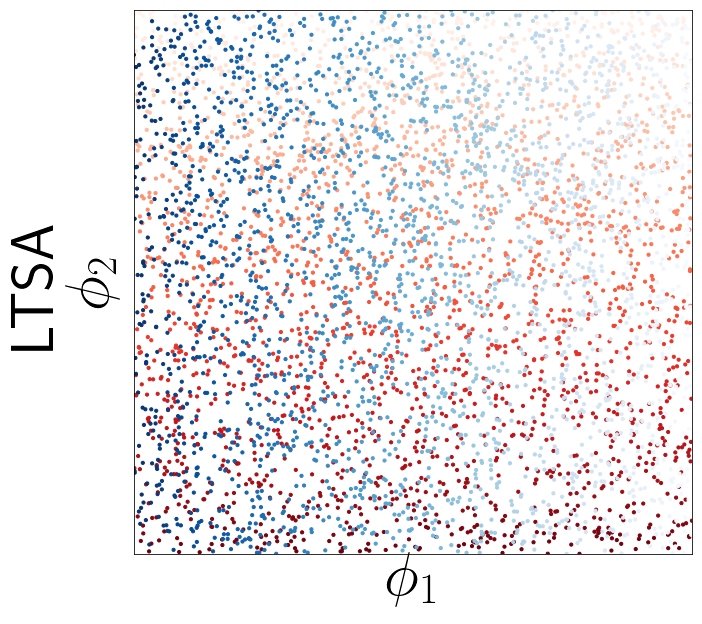

In [89]:
%matplotlib inline
fig, axes_all = plt.subplots(figsize=(10,10) )
swiss_ltsa = N_ltsa.data
axes_all.scatter(swiss_ltsa[inds1,0],swiss_ltsa[inds1,1], s = 10, alpha = 1, c = swiss_internal[inds1,0], cmap = 'Reds')
axes_all.scatter(swiss_ltsa[inds2,0],swiss_ltsa[inds2,1], s =10, alpha = 1, c = swiss_internal[inds2,1], cmap = 'Blues')
axes_all.set_xlim(swiss_ltsa[:,0].min(), swiss_ltsa[:,0].max())
axes_all.set_ylim(swiss_ltsa[:,1].min(), swiss_ltsa[:,1].max())
axes_all.set_xticks([])
axes_all.set_yticks([])
#axes_all[3,0].set_ylabel(r'$\phi_2$')
axes_all.set_xlabel(r'$\phi_1$', fontsize = 60)
axes_all.set_ylabel(r'$\phi_2$', fontsize = 60)
fig.text(-0.01, 0.5, 'LTSA', ha='center', va='center', rotation='vertical', fontsize = 60)

plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/sr_ltsa', bbox_inches = "tight")



In [21]:
isomap = Isomap(n_components=n_components, eigen_solver='arpack',geom=experiment.M.geom)
embed_isomap = isomap.fit_transform(experiment.M.data)

/Users/samsonkoelle/anaconda3/envs/manifold_env_april/lib/python3.5/site-packages/sklearn/utils/validation.py:457: DeprecationWarning: Passing 'None' to parameter 'accept_sparse' in methods check_array and check_X_y is deprecated in version 0.19 and will be removed in 0.21. Use 'accept_sparse=False'  instead.
  " instead.", DeprecationWarning)


In [22]:
N_isomap = RiemannianManifold(embed_isomap,2)
geom_isomap = experiment.M.geom
geom_isomap.rmetric = RiemannMetric(N_isomap.data,experiment.M.geom.laplacian_matrix,n_dim=d)
geom_isomap.rmetric.get_rmetric()
N_isomap.geom = geom_isomap

In [24]:
swiss_isomap = N_isomap.data

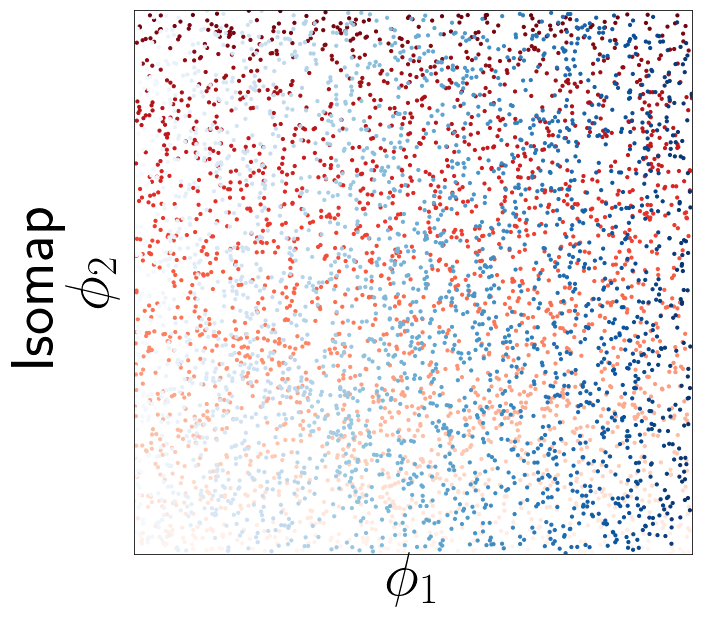

In [88]:
%matplotlib inline
fig, axes_all = plt.subplots(figsize=(10,10) )

axes_all.scatter(swiss_isomap[inds1,0],swiss_isomap[inds1,1], s = 10, alpha = 1, c = swiss_internal[inds1,0], cmap = 'Reds')
axes_all.scatter(swiss_isomap[inds2,0],swiss_isomap[inds2,1], s =10, alpha = 1, c = swiss_internal[inds2,1], cmap = 'Blues')
axes_all.set_xlim(swiss_isomap[:,0].min(), swiss_isomap[:,0].max())
axes_all.set_ylim(swiss_isomap[:,1].min(), swiss_isomap[:,1].max())
axes_all.set_xticks([])
axes_all.set_yticks([])
#axes_all[2,0].set_ylabel(r'$\phi_2$')
#axes_all[2,0].set_xlabel(r'$\phi_1$')
axes_all.set_xlabel(r'$\phi_1$', fontsize = 60)
axes_all.set_ylabel(r'$\phi_2$', fontsize = 60)
fig.text(-0.01, 0.5, 'Isomap', ha='center', va='center', rotation='vertical', fontsize = 60)
plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/sr_isomap', bbox_inches = "tight")


In [27]:
N_internal.geom = experiment.M.geom

In [30]:
print('pre-gradient acquisition')
print(datetime.datetime.now())
replicates_internal = {}
replicates_isomap = {}
replicates_spectral = {}
replicates_ltsa = {}
for i in range(nreps):
    print(i)
    selected_points = np.random.choice(list(range(n)),nsel,replace = False)
    selected_points_save[i] = selected_points
    replicates_internal[i] = Replicate()
    replicates_internal[i].nsel = nsel
    replicates_internal[i].selected_points = selected_points
    replicates_internal[i].df_M,replicates_internal[i].dg_M,replicates_internal[i].dg_x ,replicates_internal[i].dgx_norm   = get_grads_noshape_swiss(experiment, experiment.M,  N_internal, selected_points)
    replicates_internal[i].dg_M = np.swapaxes(replicates_internal[i].dg_M, 1,2)
 
    replicates_isomap[i] = Replicate()
    replicates_isomap[i].selected_points = selected_points
    replicates_isomap[i].df_M,replicates_isomap[i].dg_M,replicates_isomap[i].dg_x ,replicates_isomap[i].dgx_norm   = get_grads_noshape_swiss(experiment, experiment.M,  N_isomap, selected_points)
    replicates_isomap[i].dg_M = np.swapaxes(replicates_isomap[i].dg_M, 1,2)
    
    replicates_spectral[i] = Replicate()
    replicates_spectral[i].selected_points = selected_points
    replicates_spectral[i].df_M,replicates_spectral[i].dg_M,replicates_spectral[i].dg_x ,replicates_spectral[i].dgx_norm   = get_grads_noshape_swiss(experiment, experiment.M,  N_spectral, selected_points)
    replicates_spectral[i].dg_M = np.swapaxes(replicates_spectral[i].dg_M, 1,2)
    
    replicates_ltsa[i] = Replicate()
    replicates_ltsa[i].selected_points = selected_points
    replicates_ltsa[i].df_M,replicates_ltsa[i].dg_M,replicates_ltsa[i].dg_x ,replicates_ltsa[i].dgx_norm   = get_grads_noshape_swiss(experiment, experiment.M,  N_ltsa, selected_points)
    replicates_ltsa[i].dg_M = np.swapaxes(replicates_ltsa[i].dg_M, 1,2)
    



pre-gradient acquisition
2021-01-18 12:34:52.407085
0
1


In [33]:
selected_points_save = np.asarray(selected_points_save, dtype = int)
gl_itermax = 500
lambdas_start = [0.,.0005 * np.sqrt(nsel * p)]
max_search = 30
reg_l2 = 0.
card = dim
tol = 1e-14
learning_rate = 100

from pathos.multiprocessing import ProcessingPool as Pool
from codes.flasso.GradientGroupLasso import batch_stream, get_sr_lambda_sam_parallel

print('pre-gradient descent')
print(datetime.datetime.now())
cores = 16
# pcor = Pool(cores)
# results = pcor.map(lambda replicate: get_sr_lambda_sam_parallel(replicate, gl_itermax, lambdas_start,reg_l2, max_search, card, tol,learning_rate), batch_stream(replicates))

results_internal = {}
results_spectral = {}
results_isomap = {}
results_ltsa = {}
for r in range(nreps):
    print(r)
    results_internal[r] = Replicate()
    results_internal[r] = get_sr_lambda_sam_parallel(replicates_internal[r], gl_itermax, lambdas_start,reg_l2, max_search, card, tol,learning_rate)

    results_spectral[r] = Replicate()
    results_spectral[r] = get_sr_lambda_sam_parallel(replicates_spectral[r], gl_itermax, lambdas_start,reg_l2, max_search, card, tol,learning_rate)

    results_ltsa[r] = Replicate()
    results_ltsa[r] = get_sr_lambda_sam_parallel(replicates_ltsa[r], gl_itermax, lambdas_start,reg_l2, max_search, card, tol,learning_rate)

    results_isomap[r] = Replicate()
    results_isomap[r] = get_sr_lambda_sam_parallel(replicates_isomap[r], gl_itermax, lambdas_start,reg_l2, max_search, card, tol,learning_rate)


pre-gradient descent
2021-01-18 12:36:44.053769
0
initializing lambda search
0
lr 100
lr 50.0
lr 25.0
lr 12.5
lr 6.25
lr 3.125
lr 1.5625
lr 0.78125
lr 0.390625
lr 0.1953125
lr 0.09765625
1
lr 0.09765625
2
lr 0.09765625
3
lr 0.09765625
4
lr 0.09765625
5
lr 0.09765625
6
lr 0.09765625
7
lr 0.09765625
8
lr 0.09765625
9
lr 0.09765625
10
lr 0.09765625
11
lr 0.09765625
12
lr 0.09765625
13
lr 0.09765625
14
lr 0.09765625
15
lr 0.09765625
16
lr 0.09765625
17
lr 0.09765625
18
lr 0.09765625
lr 0.048828125
19
lr 0.048828125
20
lr 0.048828125
21
lr 0.048828125
22
lr 0.048828125
23
lr 0.048828125
24
lr 0.048828125
25
lr 0.048828125
26
lr 0.048828125
27
lr 0.048828125
28
lr 0.048828125
lr 0.0244140625
lr 0.01220703125
lr 0.006103515625
lr 0.0030517578125
lr 0.00152587890625
lr 0.000762939453125
lr 0.0003814697265625
lr 0.00019073486328125
lr 9.5367431640625e-05
lr 4.76837158203125e-05
lr 2.384185791015625e-05
lr 1.1920928955078125e-05
29
lr 1.1920928955078125e-05
lr 5.9604644775390625e-06
lr 2.9802322

lr 5.9604644775390625e-06
73
lr 5.9604644775390625e-06
74
lr 5.9604644775390625e-06
75
lr 5.9604644775390625e-06
76
lr 5.9604644775390625e-06
77
lr 5.9604644775390625e-06
78
lr 5.9604644775390625e-06
79
lr 5.9604644775390625e-06
80
lr 5.9604644775390625e-06
81
lr 5.9604644775390625e-06
82
lr 5.9604644775390625e-06
83
lr 5.9604644775390625e-06
84
lr 5.9604644775390625e-06
85
lr 5.9604644775390625e-06
86
lr 5.9604644775390625e-06
87
lr 5.9604644775390625e-06
88
lr 5.9604644775390625e-06
89
lr 5.9604644775390625e-06
90
lr 5.9604644775390625e-06
91
lr 5.9604644775390625e-06
92
lr 5.9604644775390625e-06
lr 2.9802322387695312e-06
93
lr 2.9802322387695312e-06
94
lr 2.9802322387695312e-06
95
lr 2.9802322387695312e-06
96
lr 2.9802322387695312e-06
97
lr 2.9802322387695312e-06
98
lr 2.9802322387695312e-06
99
lr 2.9802322387695312e-06
100
lr 2.9802322387695312e-06
101
lr 2.9802322387695312e-06
102
lr 2.9802322387695312e-06
103
lr 2.9802322387695312e-06
104
lr 2.9802322387695312e-06
105
lr 2.980232

lr 7.450580596923828e-07
352
lr 7.450580596923828e-07
353
lr 7.450580596923828e-07
354
lr 7.450580596923828e-07
355
lr 7.450580596923828e-07
356
lr 7.450580596923828e-07
357
lr 7.450580596923828e-07
358
lr 7.450580596923828e-07
359
lr 7.450580596923828e-07
360
lr 7.450580596923828e-07
361
lr 7.450580596923828e-07
362
lr 7.450580596923828e-07
363
lr 7.450580596923828e-07
364
lr 7.450580596923828e-07
365
lr 7.450580596923828e-07
366
lr 7.450580596923828e-07
367
lr 7.450580596923828e-07
368
lr 7.450580596923828e-07
369
lr 7.450580596923828e-07
370
lr 7.450580596923828e-07
371
lr 7.450580596923828e-07
372
lr 7.450580596923828e-07
373
lr 7.450580596923828e-07
374
lr 7.450580596923828e-07
375
lr 7.450580596923828e-07
376
lr 7.450580596923828e-07
377
lr 7.450580596923828e-07
378
lr 7.450580596923828e-07
379
lr 7.450580596923828e-07
380
lr 7.450580596923828e-07
381
lr 7.450580596923828e-07
382
lr 7.450580596923828e-07
383
lr 7.450580596923828e-07
384
lr 7.450580596923828e-07
385
lr 7.450580596

lr 0.09765625
251
lr 0.09765625
252
lr 0.09765625
253
lr 0.09765625
254
lr 0.09765625
255
lr 0.09765625
256
lr 0.09765625
257
lr 0.09765625
258
lr 0.09765625
259
lr 0.09765625
260
lr 0.09765625
261
lr 0.09765625
262
lr 0.09765625
263
lr 0.09765625
264
lr 0.09765625
265
lr 0.09765625
266
lr 0.09765625
267
lr 0.09765625
268
lr 0.09765625
269
lr 0.09765625
270
lr 0.09765625
converged 0.007984359711335655
we did it [0 1]
initializing lambda search
0
lr 100
lr 50.0
lr 25.0
lr 12.5
lr 6.25
lr 3.125
lr 1.5625
lr 0.78125
lr 0.390625
lr 0.1953125
lr 0.09765625
1
lr 0.09765625
2
lr 0.09765625
3
lr 0.09765625
4
lr 0.09765625
5
lr 0.09765625
6
lr 0.09765625
7
lr 0.09765625
8
lr 0.09765625
9
lr 0.09765625
10
lr 0.09765625
11
lr 0.09765625
12
lr 0.09765625
13
lr 0.09765625
14
lr 0.09765625
15
lr 0.09765625
16
lr 0.09765625
17
lr 0.09765625
18
lr 0.09765625
lr 0.048828125
19
lr 0.048828125
20
lr 0.048828125
21
lr 0.048828125
22
lr 0.048828125
23
lr 0.048828125
24
lr 0.048828125
25
lr 0.048828125
26
l

lr 3.725290298461914e-07
92
lr 3.725290298461914e-07
93
lr 3.725290298461914e-07
94
lr 3.725290298461914e-07
95
lr 3.725290298461914e-07
96
lr 3.725290298461914e-07
97
lr 3.725290298461914e-07
98
lr 3.725290298461914e-07
99
lr 3.725290298461914e-07
100
lr 3.725290298461914e-07
101
lr 3.725290298461914e-07
102
lr 3.725290298461914e-07
103
lr 3.725290298461914e-07
104
lr 3.725290298461914e-07
105
lr 3.725290298461914e-07
106
lr 3.725290298461914e-07
107
lr 3.725290298461914e-07
lr 1.862645149230957e-07
108
lr 1.862645149230957e-07
109
lr 1.862645149230957e-07
110
lr 1.862645149230957e-07
111
lr 1.862645149230957e-07
112
lr 1.862645149230957e-07
113
lr 1.862645149230957e-07
114
lr 1.862645149230957e-07
115
lr 1.862645149230957e-07
116
lr 1.862645149230957e-07
117
lr 1.862645149230957e-07
118
lr 1.862645149230957e-07
119
lr 1.862645149230957e-07
120
lr 1.862645149230957e-07
121
lr 1.862645149230957e-07
122
lr 1.862645149230957e-07
123
lr 1.862645149230957e-07
124
lr 1.862645149230957e-07
1

lr 9.313225746154785e-08
387
lr 9.313225746154785e-08
388
lr 9.313225746154785e-08
389
lr 9.313225746154785e-08
390
lr 9.313225746154785e-08
391
lr 9.313225746154785e-08
392
lr 9.313225746154785e-08
393
lr 9.313225746154785e-08
394
lr 9.313225746154785e-08
395
lr 9.313225746154785e-08
396
lr 9.313225746154785e-08
397
lr 9.313225746154785e-08
398
lr 9.313225746154785e-08
399
lr 9.313225746154785e-08
400
lr 9.313225746154785e-08
401
lr 9.313225746154785e-08
402
lr 9.313225746154785e-08
403
lr 9.313225746154785e-08
404
lr 9.313225746154785e-08
405
lr 9.313225746154785e-08
406
lr 9.313225746154785e-08
407
lr 9.313225746154785e-08
408
lr 9.313225746154785e-08
409
lr 9.313225746154785e-08
410
lr 9.313225746154785e-08
411
lr 9.313225746154785e-08
412
lr 9.313225746154785e-08
413
lr 9.313225746154785e-08
414
lr 9.313225746154785e-08
415
lr 9.313225746154785e-08
416
lr 9.313225746154785e-08
417
lr 9.313225746154785e-08
418
lr 9.313225746154785e-08
419
lr 9.313225746154785e-08
420
lr 9.313225746

9
lr 0.09765625
10
lr 0.09765625
11
lr 0.09765625
12
lr 0.09765625
13
lr 0.09765625
14
lr 0.09765625
15
lr 0.09765625
16
lr 0.09765625
17
lr 0.09765625
18
lr 0.09765625
lr 0.048828125
19
lr 0.048828125
20
lr 0.048828125
21
lr 0.048828125
22
lr 0.048828125
23
lr 0.048828125
24
lr 0.048828125
25
lr 0.048828125
26
lr 0.048828125
lr 0.0244140625
27
lr 0.0244140625
lr 0.01220703125
lr 0.006103515625
lr 0.0030517578125
lr 0.00152587890625
lr 0.000762939453125
lr 0.0003814697265625
lr 0.00019073486328125
lr 9.5367431640625e-05
lr 4.76837158203125e-05
converged 0.0
0
lr 100
lr 50.0
lr 25.0
lr 12.5
lr 6.25
lr 3.125
lr 1.5625
lr 0.78125
lr 0.390625
lr 0.1953125
lr 0.09765625
1
lr 0.09765625
2
lr 0.09765625
3
lr 0.09765625
4
lr 0.09765625
5
lr 0.09765625
6
lr 0.09765625
7
lr 0.09765625
8
lr 0.09765625
9
lr 0.09765625
10
lr 0.09765625
11
lr 0.09765625
12
lr 0.09765625
13
lr 0.09765625
14
lr 0.09765625
15
lr 0.09765625
16
lr 0.09765625
17
lr 0.09765625
18
lr 0.09765625
19
lr 0.09765625
20
lr 0.0976

lr 2.9802322387695312e-06
135
lr 2.9802322387695312e-06
136
lr 2.9802322387695312e-06
137
lr 2.9802322387695312e-06
138
lr 2.9802322387695312e-06
139
lr 2.9802322387695312e-06
140
lr 2.9802322387695312e-06
141
lr 2.9802322387695312e-06
142
lr 2.9802322387695312e-06
143
lr 2.9802322387695312e-06
144
lr 2.9802322387695312e-06
145
lr 2.9802322387695312e-06
146
lr 2.9802322387695312e-06
147
lr 2.9802322387695312e-06
148
lr 2.9802322387695312e-06
149
lr 2.9802322387695312e-06
150
lr 2.9802322387695312e-06
151
lr 2.9802322387695312e-06
152
lr 2.9802322387695312e-06
153
lr 2.9802322387695312e-06
154
lr 2.9802322387695312e-06
155
lr 2.9802322387695312e-06
156
lr 2.9802322387695312e-06
157
lr 2.9802322387695312e-06
158
lr 2.9802322387695312e-06
159
lr 2.9802322387695312e-06
160
lr 2.9802322387695312e-06
161
lr 2.9802322387695312e-06
162
lr 2.9802322387695312e-06
163
lr 2.9802322387695312e-06
164
lr 2.9802322387695312e-06
165
lr 2.9802322387695312e-06
166
lr 2.9802322387695312e-06
167
lr 2.98023

lr 7.450580596923828e-07
421
lr 7.450580596923828e-07
422
lr 7.450580596923828e-07
423
lr 7.450580596923828e-07
424
lr 7.450580596923828e-07
425
lr 7.450580596923828e-07
426
lr 7.450580596923828e-07
427
lr 7.450580596923828e-07
428
lr 7.450580596923828e-07
429
lr 7.450580596923828e-07
430
lr 7.450580596923828e-07
431
lr 7.450580596923828e-07
432
lr 7.450580596923828e-07
433
lr 7.450580596923828e-07
434
lr 7.450580596923828e-07
435
lr 7.450580596923828e-07
436
lr 7.450580596923828e-07
437
lr 7.450580596923828e-07
438
lr 7.450580596923828e-07
439
lr 7.450580596923828e-07
440
lr 7.450580596923828e-07
441
lr 7.450580596923828e-07
442
lr 7.450580596923828e-07
443
lr 7.450580596923828e-07
444
lr 7.450580596923828e-07
445
lr 7.450580596923828e-07
446
lr 7.450580596923828e-07
447
lr 7.450580596923828e-07
448
lr 7.450580596923828e-07
449
lr 7.450580596923828e-07
450
lr 7.450580596923828e-07
451
lr 7.450580596923828e-07
452
lr 7.450580596923828e-07
453
lr 7.450580596923828e-07
454
lr 7.450580596

lr 1.1920928955078125e-05
52
lr 1.1920928955078125e-05
53
lr 1.1920928955078125e-05
54
lr 1.1920928955078125e-05
55
lr 1.1920928955078125e-05
56
lr 1.1920928955078125e-05
57
lr 1.1920928955078125e-05
58
lr 1.1920928955078125e-05
59
lr 1.1920928955078125e-05
lr 5.9604644775390625e-06
60
lr 5.9604644775390625e-06
61
lr 5.9604644775390625e-06
62
lr 5.9604644775390625e-06
63
lr 5.9604644775390625e-06
64
lr 5.9604644775390625e-06
65
lr 5.9604644775390625e-06
66
lr 5.9604644775390625e-06
67
lr 5.9604644775390625e-06
lr 2.9802322387695312e-06
68
lr 2.9802322387695312e-06
69
lr 2.9802322387695312e-06
70
lr 2.9802322387695312e-06
71
lr 2.9802322387695312e-06
72
lr 2.9802322387695312e-06
73
lr 2.9802322387695312e-06
74
lr 2.9802322387695312e-06
75
lr 2.9802322387695312e-06
76
lr 2.9802322387695312e-06
77
lr 2.9802322387695312e-06
78
lr 2.9802322387695312e-06
79
lr 2.9802322387695312e-06
80
lr 2.9802322387695312e-06
lr 1.4901161193847656e-06
81
lr 1.4901161193847656e-06
82
lr 1.4901161193847656e-

lr 3.725290298461914e-07
334
lr 3.725290298461914e-07
335
lr 3.725290298461914e-07
336
lr 3.725290298461914e-07
337
lr 3.725290298461914e-07
338
lr 3.725290298461914e-07
339
lr 3.725290298461914e-07
340
lr 3.725290298461914e-07
341
lr 3.725290298461914e-07
342
lr 3.725290298461914e-07
343
lr 3.725290298461914e-07
344
lr 3.725290298461914e-07
345
lr 3.725290298461914e-07
346
lr 3.725290298461914e-07
347
lr 3.725290298461914e-07
348
lr 3.725290298461914e-07
349
lr 3.725290298461914e-07
350
lr 3.725290298461914e-07
351
lr 3.725290298461914e-07
352
lr 3.725290298461914e-07
353
lr 3.725290298461914e-07
354
lr 3.725290298461914e-07
355
lr 3.725290298461914e-07
356
lr 3.725290298461914e-07
357
lr 3.725290298461914e-07
358
lr 3.725290298461914e-07
359
lr 3.725290298461914e-07
360
lr 3.725290298461914e-07
361
lr 3.725290298461914e-07
362
lr 3.725290298461914e-07
363
lr 3.725290298461914e-07
364
lr 3.725290298461914e-07
365
lr 3.725290298461914e-07
366
lr 3.725290298461914e-07
367
lr 3.725290298

lr 0.09765625
199
lr 0.09765625
200
lr 0.09765625
201
lr 0.09765625
202
lr 0.09765625
203
lr 0.09765625
204
lr 0.09765625
205
lr 0.09765625
206
lr 0.09765625
207
lr 0.09765625
208
lr 0.09765625
209
lr 0.09765625
210
lr 0.09765625
211
lr 0.09765625
212
lr 0.09765625
213
lr 0.09765625
214
lr 0.09765625
215
lr 0.09765625
216
lr 0.09765625
217
lr 0.09765625
218
lr 0.09765625
219
lr 0.09765625
220
lr 0.09765625
221
lr 0.09765625
222
lr 0.09765625
223
lr 0.09765625
224
lr 0.09765625
225
lr 0.09765625
226
lr 0.09765625
227
lr 0.09765625
228
lr 0.09765625
229
lr 0.09765625
230
lr 0.09765625
231
lr 0.09765625
232
lr 0.09765625
233
lr 0.09765625
234
lr 0.09765625
235
lr 0.09765625
236
lr 0.09765625
237
lr 0.09765625
238
lr 0.09765625
239
lr 0.09765625
240
lr 0.09765625
241
lr 0.09765625
242
lr 0.09765625
243
lr 0.09765625
244
lr 0.09765625
245
lr 0.09765625
246
lr 0.09765625
247
lr 0.09765625
248
lr 0.09765625
249
lr 0.09765625
250
lr 0.09765625
251
lr 0.09765625
252
lr 0.09765625
253
lr 0.09765

lr 7.450580596923828e-07
248
lr 7.450580596923828e-07
249
lr 7.450580596923828e-07
250
lr 7.450580596923828e-07
251
lr 7.450580596923828e-07
252
lr 7.450580596923828e-07
253
lr 7.450580596923828e-07
254
lr 7.450580596923828e-07
255
lr 7.450580596923828e-07
256
lr 7.450580596923828e-07
257
lr 7.450580596923828e-07
258
lr 7.450580596923828e-07
259
lr 7.450580596923828e-07
260
lr 7.450580596923828e-07
261
lr 7.450580596923828e-07
262
lr 7.450580596923828e-07
263
lr 7.450580596923828e-07
264
lr 7.450580596923828e-07
265
lr 7.450580596923828e-07
266
lr 7.450580596923828e-07
267
lr 7.450580596923828e-07
268
lr 7.450580596923828e-07
269
lr 7.450580596923828e-07
270
lr 7.450580596923828e-07
271
lr 7.450580596923828e-07
272
lr 7.450580596923828e-07
273
lr 7.450580596923828e-07
274
lr 7.450580596923828e-07
275
lr 7.450580596923828e-07
276
lr 7.450580596923828e-07
277
lr 7.450580596923828e-07
278
lr 7.450580596923828e-07
279
lr 7.450580596923828e-07
280
lr 7.450580596923828e-07
281
lr 7.450580596

lr 0.09765625
55
lr 0.09765625
56
lr 0.09765625
57
lr 0.09765625
58
lr 0.09765625
59
lr 0.09765625
60
lr 0.09765625
61
lr 0.09765625
62
lr 0.09765625
63
lr 0.09765625
64
lr 0.09765625
65
lr 0.09765625
66
lr 0.09765625
67
lr 0.09765625
68
lr 0.09765625
69
lr 0.09765625
70
lr 0.09765625
71
lr 0.09765625
72
lr 0.09765625
73
lr 0.09765625
74
lr 0.09765625
75
lr 0.09765625
76
lr 0.09765625
77
lr 0.09765625
78
lr 0.09765625
79
lr 0.09765625
80
lr 0.09765625
81
lr 0.09765625
82
lr 0.09765625
83
lr 0.09765625
84
lr 0.09765625
85
lr 0.09765625
86
lr 0.09765625
87
lr 0.09765625
88
lr 0.09765625
89
lr 0.09765625
90
lr 0.09765625
91
lr 0.09765625
92
lr 0.09765625
93
lr 0.09765625
94
lr 0.09765625
95
lr 0.09765625
96
lr 0.09765625
97
lr 0.09765625
98
lr 0.09765625
99
lr 0.09765625
100
lr 0.09765625
101
lr 0.09765625
102
lr 0.09765625
103
lr 0.09765625
104
lr 0.09765625
105
lr 0.09765625
106
lr 0.09765625
107
lr 0.09765625
108
lr 0.09765625
109
lr 0.09765625
110
lr 0.09765625
111
lr 0.09765625
112
l

In [39]:
from einops import rearrange

In [48]:
nreps = 1
#replicates_toluene ={}
for r in range(nreps):
    #r = 0 
    #replicates_toluene[r ] = Replicate()
    cs = rearrange(np.asarray(list(results_internal[r][1].values())), 'l n p m -> l m n p')
    xaxis = np.asarray(np.asarray(list(results_internal[r][1].keys())))
    xaxis_reorder = xaxis[xaxis.argsort()]
    cs_reorder = cs[xaxis.argsort()]
    xaxis_reorder = xaxis[xaxis.argsort()]
    replicates_internal[r].cs = cs
    replicates_internal[r].cs_reorder = cs_reorder
    replicates_internal[r].xaxis_reorder = xaxis_reorder
    replicates_internal[r].xaxis = xaxis
    

In [57]:
nreps = 1
#replicates_toluene ={}
for r in range(nreps):
    #r = 0 
    #replicates_toluene[r ] = Replicate()
    cs = rearrange(np.asarray(list(results_ltsa[r][1].values())), 'l n p m -> l m n p')
    xaxis = np.asarray(np.asarray(list(results_ltsa[r][1].keys())))
    xaxis_reorder = xaxis[xaxis.argsort()]
    cs_reorder = cs[xaxis.argsort()]
    xaxis_reorder = xaxis[xaxis.argsort()]
    replicates_ltsa[r].cs = cs
    replicates_ltsa[r].cs_reorder = cs_reorder
    replicates_ltsa[r].xaxis_reorder = xaxis_reorder
    replicates_ltsa[r].xaxis = xaxis
    

In [58]:
nreps = 1
#replicates_toluene ={}
for r in range(nreps):
    #r = 0 
    #replicates_toluene[r ] = Replicate()
    cs = rearrange(np.asarray(list(results_isomap[r][1].values())), 'l n p m -> l m n p')
    xaxis = np.asarray(np.asarray(list(results_isomap[r][1].keys())))
    xaxis_reorder = xaxis[xaxis.argsort()]
    cs_reorder = cs[xaxis.argsort()]
    xaxis_reorder = xaxis[xaxis.argsort()]
    replicates_isomap[r].cs = cs
    replicates_isomap[r].cs_reorder = cs_reorder
    replicates_isomap[r].xaxis_reorder = xaxis_reorder
    replicates_isomap[r].xaxis = xaxis
    

In [59]:
nreps = 1
#replicates_toluene ={}
for r in range(nreps):
    #r = 0 
    #replicates_toluene[r ] = Replicate()
    cs = rearrange(np.asarray(list(results_spectral[r][1].values())), 'l n p m -> l m n p')
    xaxis = np.asarray(np.asarray(list(results_spectral[r][1].keys())))
    xaxis_reorder = xaxis[xaxis.argsort()]
    cs_reorder = cs[xaxis.argsort()]
    xaxis_reorder = xaxis[xaxis.argsort()]
    replicates_spectral[r].cs = cs
    replicates_spectral[r].cs_reorder = cs_reorder
    replicates_spectral[r].xaxis_reorder = xaxis_reorder
    replicates_spectral[r].xaxis = xaxis
    

In [61]:
nreps = 1
#replicates_toluene ={}
for r in range(nreps):
    #r = 0 
    #replicates_toluene[r ] = Replicate()
    cs = rearrange(np.asarray(list(results_internal[r][1].values())), 'l n p m -> l m n p')
    xaxis = np.asarray(np.asarray(list(results_internal[r][1].keys())))
    xaxis_reorder = xaxis[xaxis.argsort()]
    cs_reorder = cs[xaxis.argsort()]
    xaxis_reorder = xaxis[xaxis.argsort()]
    replicates_internal[r].cs = cs
    replicates_internal[r].cs_reorder = cs_reorder
    replicates_internal[r].xaxis_reorder = xaxis_reorder
    replicates_internal[r].xaxis = xaxis
    

In [71]:

# def plot_reg_path_ax_lambdasearch_customcolors(axes, coeffs, xaxis,fig, colors):
#     p = coeffs.shape[3]
#     q = coeffs.shape[1]
#     gnames = np.asarray(list(range(p)), dtype=str)

#     # xlabel = r"$\displaystyle \lambda$"
#     # ylabel = r"$\displaystyle \|\hat \beta_{j}\|_2$"
#     rcParams['axes.titlesize'] = 30
#     plt.rc('text', usetex=True)

#     # maxes = np.zeros(q)
#     # for k in range(q):
#     #     maxes[k] = np.linalg.norm(coeffs[:, k, :, :], axis=1).max()
#     # normax = maxes.max()
#     normax = np.sqrt(np.sum(np.sum(np.sum(coeffs ** 2, axis=1), axis=1), axis=1).max())

#     for k in range(q):
#         for j in range(p):
#             toplot = np.linalg.norm(coeffs[:, k, :, j], axis=1)
#             w = .15
#             widths = np.asarray([width(xaxis[i], w) for i in range(len(xaxis))])
#             # axes[k+1].boxplot(toplot, positions=xaxis, showfliers=False, vert=True, widths=widths,medianprops=dict(linestyle=''))
#             axes[k + 1].plot(xaxis, toplot, 'go--', linewidth=5, markersize=0, alpha=1.,
#                              color=colors[j], label=gnames[j])
#     for j in range(p):
#         toplot = np.linalg.norm(np.linalg.norm(coeffs[:, :, :, j], axis=2), axis=1)
#         # axes[0].boxplot(toplot, positions=xaxis, showfliers=False, vert=True, widths=widths,medianprops=dict(linestyle=''))
#         axes[0].plot(xaxis, toplot, 'go--', linewidth=5, markersize=0, alpha=1.,
#                      color=colors[j], label=gnames[j])

#     kkk = xaxis.copy()
#     kkk.sort()

#     # xupperindex = np.min(np.where(np.sum(np.sum(np.sum(coeffs**2, axis = 1), axis = 1), axis = 1) ==0)[0])

#     for k in range(1 + q):
#         axes[k].tick_params(labelsize=50)
#         axes[k].set_xscale('symlog')
#         axes[k].set_yscale('symlog')
#         axes[k].set_ylim(bottom=0, top=normax)
#         # axes[k].set_xlim(left = 0, right = xaxis[xupperindex])
#         if (k == 0):
#             tixx = np.hstack(
#                 [np.asarray([0]), 10 ** np.linspace(math.floor(np.log10(normax)), math.floor(np.log10(normax)) + 1, 2)])
#         if k != 0:
#             # axes[k].set_yticks(tixx)
#             axes[k].set_yticklabels([])
#         if k != q:
#             axes[k+1].set_title(r"$\phi_{{{}}}$".format(k+1), fontsize = 50)
#             #axes[k + 1].set_title(r"$\phi_{{{}}}$.format(k)")
#         if k == 0:
#             axes[k].set_title("Combined", fontdict={'fontsize': 50})
#     for k in range(1 + q):
#         axes[k].grid(True, which="both", alpha=True)
#         axes[k].set_xlabel(r"$\lambda$", fontsize = 50)
#         axes[k].set_xticklabels([])
#         axes[k].set_xticks([])
        
#     axes[0].set_ylabel(r"$||\beta_j||$", fontsize = 50)
        
# #     handles, labels = axes[0].get_legend_handles_labels()
# #     by_label = OrderedDict(zip(labels, handles))
# #     # fig.text(0.5, 0.04, xlabel, ha='center', va='center', fontsize=50)
# #     # fig.text(0.05, 0.5, ylabel, ha='center', va='center', rotation='vertical', fontsize=60)
# #     fig.subplots_adjust(right=0.75)
# #     leg_ax = fig.add_axes([.8, 0.15, 0.05, 0.7])
# #     leg_ax.axis('off')
# #     leg = leg_ax.legend(by_label.values(), gnames, prop={'size': 200 / p})
# #     # leg.set_title('Torsion', prop={'size': Function})
# #     for l in leg.get_lines():
# #         l.set_alpha(1)
#     # fig.savefig(filename + 'beta_paths_n' + str(n) + 'nsel' + str(nsel) + 'nreps' + str(
#     #    nreps))



In [63]:
m  = 2
#nsel = 5
colors = np.hstack([np.repeat('red',1), np.repeat('blue',1),np.repeat('black',49)])
from pylab import rcParams
def width(p,w):
    if p > 1.:
        output = 10**(np.log10(p)+w/2.)-10**(np.log10(p)-w/2.)
    else:
        output = w
    return(output)
import math 
from collections import OrderedDict


In [76]:

def plot_reg_path_ax_lambdasearch_customcolors(axes, coeffs, xaxis,fig, colors):
    p = coeffs.shape[3]
    q = coeffs.shape[1]
    gnames = np.asarray(list(range(p)), dtype=str)

    # xlabel = r"$\displaystyle \lambda$"
    # ylabel = r"$\displaystyle \|\hat \beta_{j}\|_2$"
    rcParams['axes.titlesize'] = 30
    plt.rc('text', usetex=True)

    # maxes = np.zeros(q)
    # for k in range(q):
    #     maxes[k] = np.linalg.norm(coeffs[:, k, :, :], axis=1).max()
    # normax = maxes.max()
    normax = np.sqrt(np.sum(np.sum(np.sum(coeffs ** 2, axis=1), axis=1), axis=1).max())

    for k in range(q):
        for j in range(p):
            toplot = np.linalg.norm(coeffs[:, k, :, j], axis=1)
            w = .15
            widths = np.asarray([width(xaxis[i], w) for i in range(len(xaxis))])
            # axes[k+1].boxplot(toplot, positions=xaxis, showfliers=False, vert=True, widths=widths,medianprops=dict(linestyle=''))
            axes[k + 1].plot(xaxis, toplot, 'go--', linewidth=10, markersize=0, alpha=1.,
                             color=colors[j], label=gnames[j])
    for j in range(p):
        toplot = np.linalg.norm(np.linalg.norm(coeffs[:, :, :, j], axis=2), axis=1)
        # axes[0].boxplot(toplot, positions=xaxis, showfliers=False, vert=True, widths=widths,medianprops=dict(linestyle=''))
        axes[0].plot(xaxis, toplot, 'go--', linewidth=10, markersize=0, alpha=.5,
                     color=colors[j], label=gnames[j])

    kkk = xaxis.copy()
    kkk.sort()

    # xupperindex = np.min(np.where(np.sum(np.sum(np.sum(coeffs**2, axis = 1), axis = 1), axis = 1) ==0)[0])

    for k in range(1 + q):
        axes[k].tick_params(labelsize=50)
        axes[k].set_xscale('symlog')
        axes[k].set_yscale('symlog')
        axes[k].set_ylim(bottom=0, top=normax)
        # axes[k].set_xlim(left = 0, right = xaxis[xupperindex])
        if (k == 0):
            tixx = np.hstack(
                [np.asarray([0]), 10 ** np.linspace(math.floor(np.log10(normax)), math.floor(np.log10(normax)) + 1, 2)])
        if k != 0:
            # axes[k].set_yticks(tixx)
            axes[k].set_yticklabels([])
        if k != q:
            axes[k+1].set_title(r"$\phi_{{{}}}$".format(k+1), fontsize = 50)
            #axes[k + 1].set_title(r"$\phi_{{{}}}$.format(k)")
        if k == 0:
            axes[k].set_title("Combined", fontdict={'fontsize': 50})
    for k in range(1 + q):
        axes[k].grid(True, which="both", alpha=True)
        axes[k].set_xlabel(r"$\lambda$", fontsize = 50)
        axes[k].set_xticklabels([])
        axes[k].set_xticks([])
        
    axes[0].set_ylabel(r"$||\beta_j||$", fontsize = 50)
        

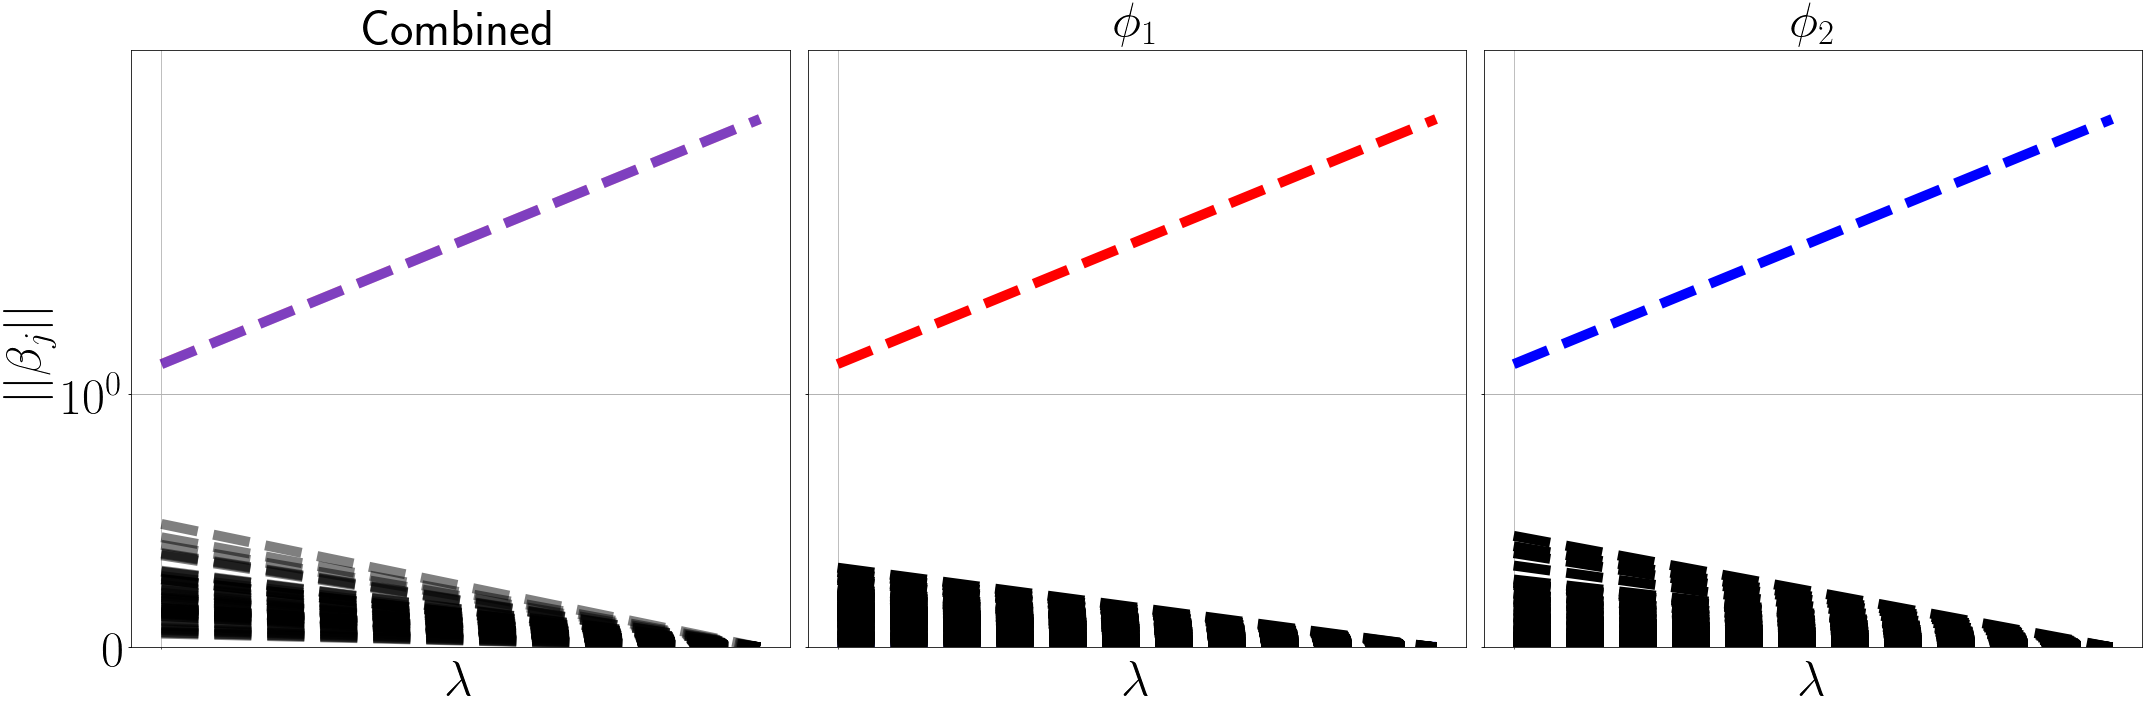

In [81]:
%matplotlib inline
fig, axes_all = plt.subplots(1,3, figsize=(30,10) )

plot_reg_path_ax_lambdasearch_customcolors(axes_all, replicates_internal[0].cs_reorder, replicates_internal[0].xaxis_reorder * np.sqrt(m * nsel), fig,colors)
#axes_all.colorbar('off')
plt.tight_layout()
plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/sr_internal_mflasso', bbox_inches = "tight")


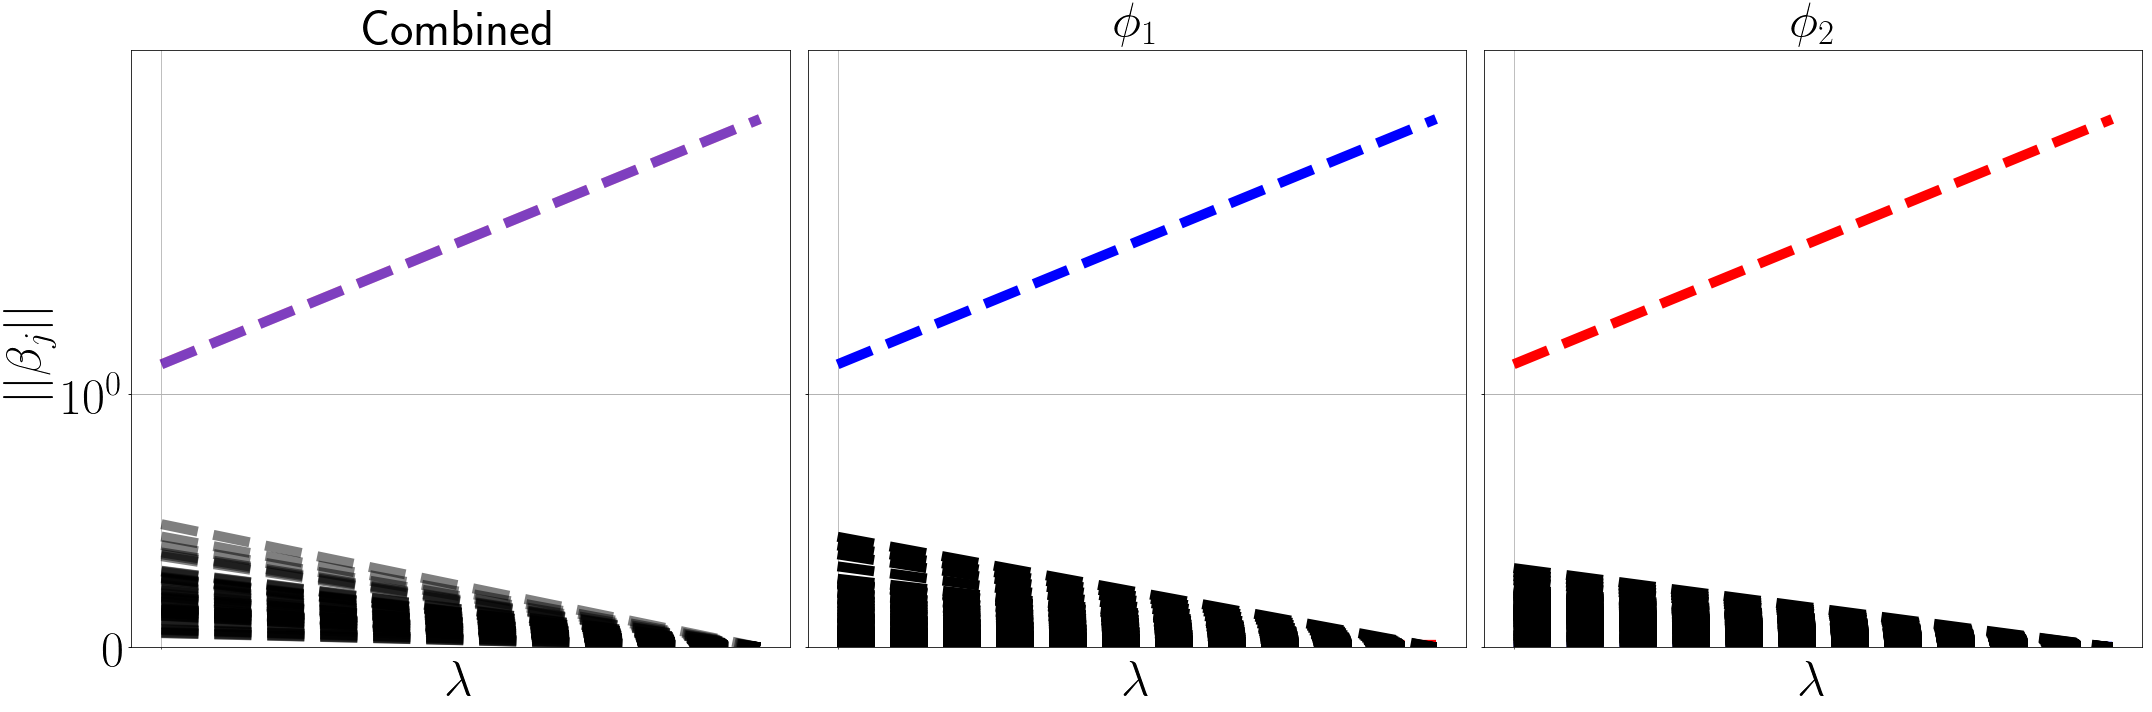

In [85]:
%matplotlib inline
fig, axes_all = plt.subplots(1,3, figsize=(30,10) )

plot_reg_path_ax_lambdasearch_customcolors(axes_all, replicates_ltsa[0].cs_reorder, replicates_ltsa[0].xaxis_reorder * np.sqrt(m * nsel), fig,colors)
#axes_all.colorbar('off')
plt.tight_layout()
plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/sr_ltsa_mflasso', bbox_inches = "tight")


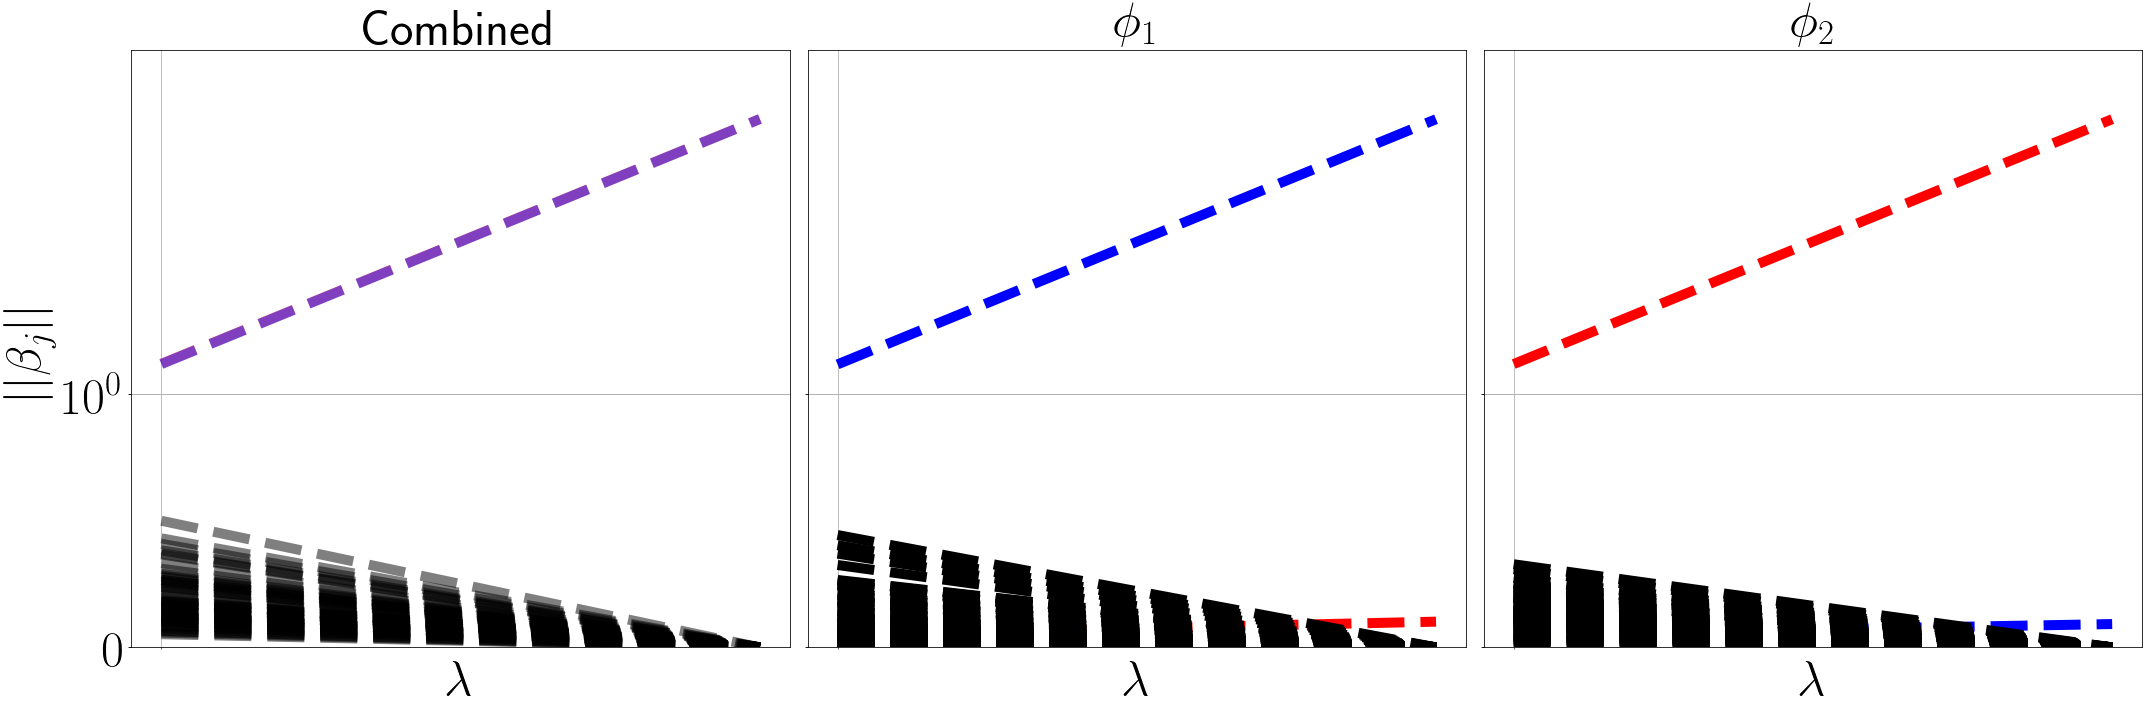

In [86]:
%matplotlib inline
fig, axes_all = plt.subplots(1,3, figsize=(30,10) )

plot_reg_path_ax_lambdasearch_customcolors(axes_all, replicates_spectral[0].cs_reorder, replicates_spectral[0].xaxis_reorder * np.sqrt(m * nsel), fig,colors)
#axes_all.colorbar('off')
plt.tight_layout()
plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/sr_spectral_mflasso', bbox_inches = "tight")


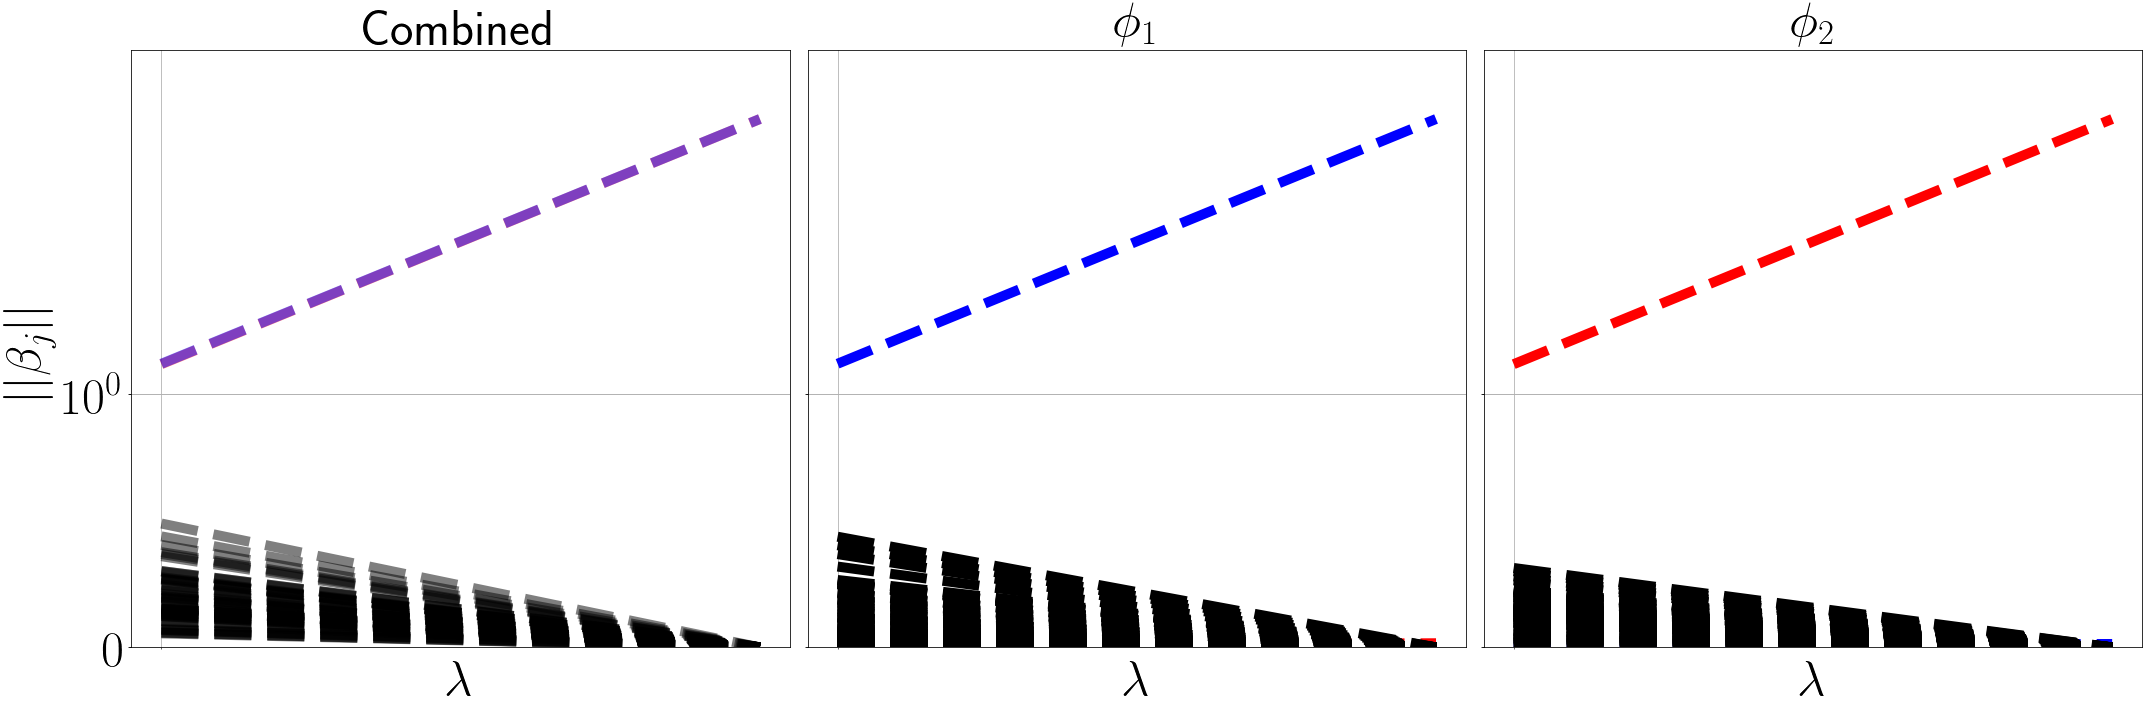

In [87]:
%matplotlib inline
fig, axes_all = plt.subplots(1,3, figsize=(30,10) )

plot_reg_path_ax_lambdasearch_customcolors(axes_all, replicates_isomap[0].cs_reorder, replicates_isomap[0].xaxis_reorder * np.sqrt(m * nsel), fig,colors)
#axes_all.colorbar('off')
plt.tight_layout()
plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/sr_isomap_mflasso', bbox_inches = "tight")